Praktikum zu Vorlesung
[__Modellreduktion parametrisierter Systeme__](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/)

Mario Ohlberger, Felix Schindler, Tim Keil

# Blatt 06, 29.05.2019

* Aktivieren Sie wie gewohnt ihre Arbeitsumgebung und starten Sie den Jupyter Notebook server, siehe zB [Blatt 1, Aufgabe 0](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/blatt_01__aufgaben.html#Aufgabe-0:-jupyter-Notebook-Server-starten).

* Erstellen Sie ein neues `Python 3` Notebook oder laden Sie dieses von der Homepage herunter.

* Importieren Sie `numpy` und `pymor.basic` und machen Sie `matplotlib` für das Notebook nutzbar.

In [1]:
%matplotlib notebook
import numpy as np
from pymor.basic import *
set_log_levels({'pymor': 'WARN',
                'pymor.functions.bitmap': 'CRITICAL'})

## Aufgabe 1: Clean up 

1. Erstellen Sie ein Modul `problems`, in dem Sie die Methoden `problem_B3_A1`, `problem_B3_A2`, `problem_B3_A3_parametric`, `problem_B4_A1` und `problem_B4_A1_parametric` implementieren. Diese sollen die in den jeweiligen Aufgaben von Blatt 3 und Blatt 4 definierten analytischen Probleme zurückgeben. Importieren Sie dieses Modul.

In [2]:
%cat problems.py

from pymor.basic import *


def problem_B3_A1():
    return StationaryProblem(
        domain=RectDomain([[-1., -1.], [1., 1.]]),
    
        diffusion=ConstantFunction(1, 2),
        
        rhs=ExpressionFunction('0.5 * np.pi**2 * np.cos(0.5 * np.pi * x[..., 0]) * np.cos(0.5 * np.pi * x[..., 1])', 2, ()),

        name='Blatt3_Aufgabe_1'
    )


def problem_B3_A2():
    return StationaryProblem(
        domain=RectDomain(bottom='neumann'),

        neumann_data=ConstantFunction(-1., 2),

        diffusion=ExpressionFunction('1. - (np.sqrt( (x[...,0]-0.5)**2 + (x[...,1]-0.5)**2) <= 0.3) * 0.999', 2, ()),

        name='Blatt3_Aufgabe_2'
    )


def problem_B3_A3_parametric():
    return StationaryProblem(
        domain=RectDomain(bottom='neumann'),

       neumann_data=LincombFunction(
            [ExpressionFunction('-cos(pi*x[...,0])**2', 2, ())],
            [ProjectionParameterFunctional('neum', ())]
        ),
       
        diffusion=ExpressionFunction('1. - (np.sqrt( (x[...

In [3]:
import problems

2. Testen Sie ihre implementierung indem Sie jedes Problem einmal mit einem Diameter von 1/100 diskretisieren und visualisieren. 

<IPython.core.display.Javascript object>


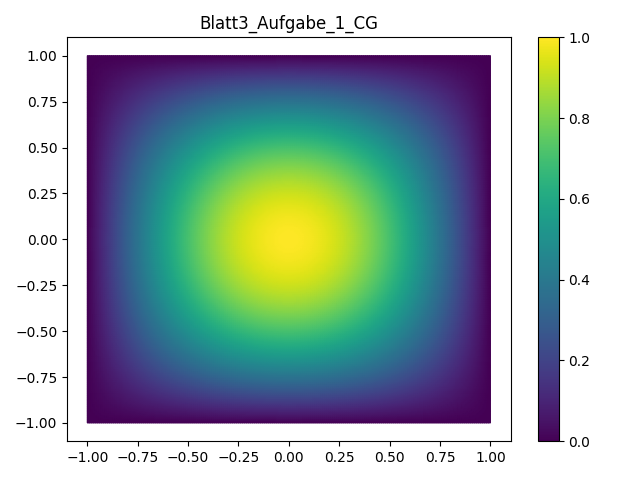

<IPython.core.display.Javascript object>


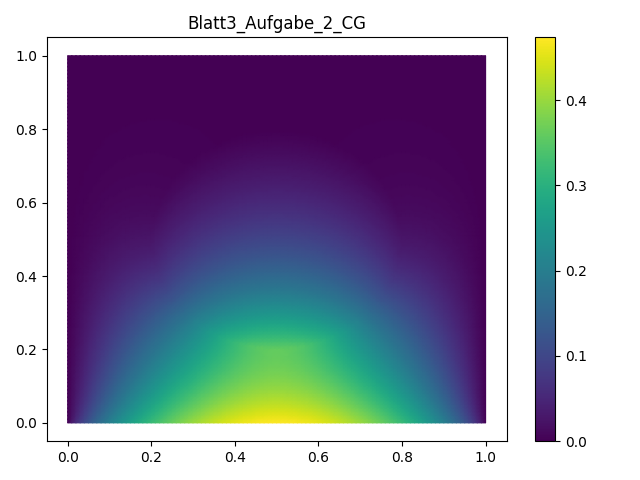

<IPython.core.display.Javascript object>


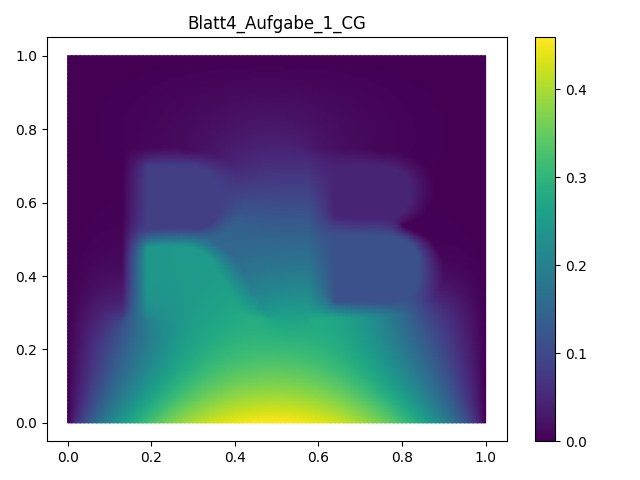

In [4]:
for f in [problems.problem_B3_A1, problems.problem_B3_A2, problems.problem_B4_A1]:
    p = f()
    d, _ = discretize_stationary_cg(p, diameter=1/100)
    d.visualize(d.solve(), legend=d.name)

<IPython.core.display.Javascript object>


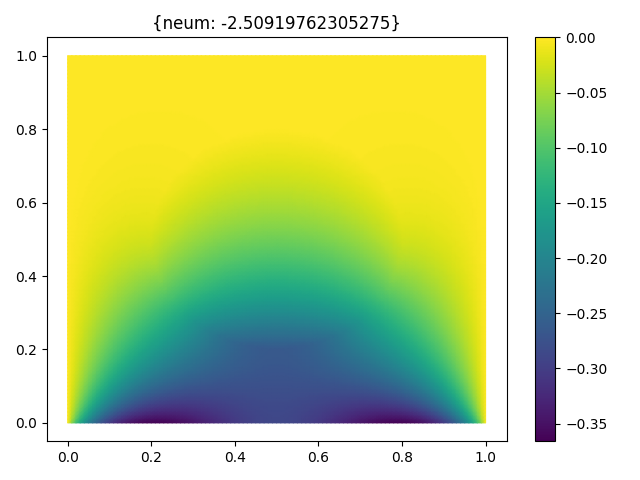

<IPython.core.display.Javascript object>


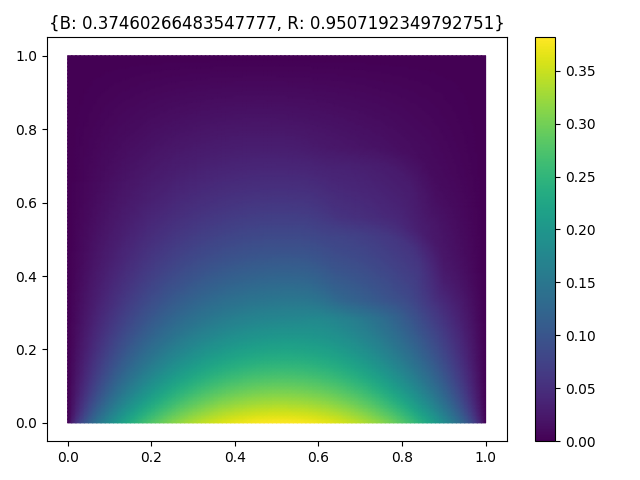

In [5]:
for f in [problems.problem_B3_A3_parametric, problems.problem_B4_A1_parametric]:
    p = f()
    d, _ = discretize_stationary_cg(p, diameter=1/100)
    mu = d.parameter_space.sample_randomly(1)[0]
    d.visualize(d.solve(mu), legend=str(mu))

3. Erstellen Sie mit Hilfe von Blatt 5 ein Modul `algorithms` mit den Methoden 
    - `orthogonal_projection(U , basis, product = None, basis_is_orthogonal=False, return_projection_matrix=False)`   
    - `greedy_approximation(U, basis_size, rtol=0, product=None)`. 
    
Der `greedy_algorithm` soll neben der genereierten Basis auch die Folge der im Algorithmus berechneten Projektionsfehler zurückgeben und zusäzlich abbrechen, sobald der relative Approximationsfehler unter die durch rtol gegebene Schranke fällt.   

In [6]:
%cat algorithms.py

import numpy as np
from pymor.algorithms.gram_schmidt import gram_schmidt


def orthogonal_projection(U, basis, product=None,
                          basis_is_orthogonal=False,
                          return_projection_matrix=False):

    rhs = product.apply2(basis, U) if product else basis.dot(U)
    if basis_is_orthogonal:
        M = np.eye(len(basis))
        v = rhs
    else:
        M = product.apply2(basis, basis) if product else basis.gramian()
        try:
            v = np.linalg.solve(M, rhs)
        except np.linalg.LinAlgError:
            v = np.zeros(rhs.shape)

    U_proj = basis.lincomb(v.T)

    if return_projection_matrix:
        return U_proj, M
    else:
        return U_proj


def greedy_approximation(U, basis_size, rtol=0, product=None, orthogonalize=False):
    # initialization
    basis = U.space.empty()
    max_errors = []

    # compute norms of vectors in U for relative approximation error computation
    norms = np.sqrt(product.pairwise_apply2(U, U) i

Tipp: Validieren Sie ihren Code indem Sie Blatt 5 Aufgabe 1 zum Beispiel mit `problem_B4_A1_parametric` wiederholen. 

In [7]:
from algorithms import orthogonal_projection, greedy_approximation

## Aufgabe 2

Im Folgenden benötigen wir ein weiteres Problem `problem_B5_A2_parametric` bei dem die Effekte der unterschiedlichen Basisgenerierungsverfahren am besten beobachtet werden können. Benutzen Sie hierfür `problem_B3_A3_parametric` aber statten Sie zusätlich die Diffusion mit einem Parameter $d_{\mu}$ (anstatt 0.001) aus. Passen Sie auch ihren `parameter_space` entsprechend an (Der Diffusionsparameter sollte in einer `range` von [0.0001,1] liegen). 


1. Wiederholen Sie die Berechnungen von Blatt 5 Aufgabe 1, wobei sie zusätzlich die Basisvektoren in `U` mittels `pymor.algorithms.gram_schmidt` mit dem Gram-Schmidt-Verfahren orthogonalisieren. Vergleichen Sie die Ergebnisse mit Blatt 5 Aufgabe 1.

In [9]:
d, _ = discretize_stationary_cg(problems.problem_B5_A2_parametric(), diameter=1/100)

Zunächst berechnen wir wieder Snapshots für den Approximationsraum (`U`) und zur Berechnung des Approximationsfehlers (`V`):

In [10]:
U = d.solution_space.empty()
print('U: ', end='')
for mu in d.parameter_space.sample_randomly(30):
    U.append(d.solve(mu))
    print('.', end='', flush=True)
    
V = d.solution_space.empty()
print('\nV: ', end='')
for mu in d.parameter_space.sample_randomly(100, seed=99):
    V.append(d.solve(mu))
    print('.', end='', flush=True)

U: ..............................
V: ....................................................................................................

Den Projektionsfehler berechnen wir wie gewohnt, verwenden dabei aber unsere neue `orthogonal_projection`-Methode:

In [11]:
errors = []
for N in range(len(U)):
    V_proj = orthogonal_projection(V, U[:N], product=d.h1_0_semi_product)
    errors.append(np.max(d.h1_0_semi_norm(V - V_proj)))

Zur Berechnung einer Orthonormalbasis verwenden wir die `pymor.algorithms.gram_schmidt.gram_schmidt`-Methode. Wenn dabei nicht `copy=False` als Parameter angegeben wird, bleibt das Ursprungs-Array `U` unverändert:

In [12]:
basis = gram_schmidt(U, product=d.h1_0_semi_product)
errors_orth = []
for N in range(len(U)):
    V_proj = orthogonal_projection(V, basis[:N], product=d.h1_0_semi_product, basis_is_orthogonal=True)
    errors_orth.append(np.max(d.h1_0_semi_norm(V - V_proj)))

Schließlich plotten wir die Ergebnisse. Dabei zeigt sich klar die erhöhte numerische Stabilität (Kondition der Projektionsmatrix ist 1), wenn die Projektionsbasis zunächst orthonormalisiert wird:

<IPython.core.display.Javascript object>


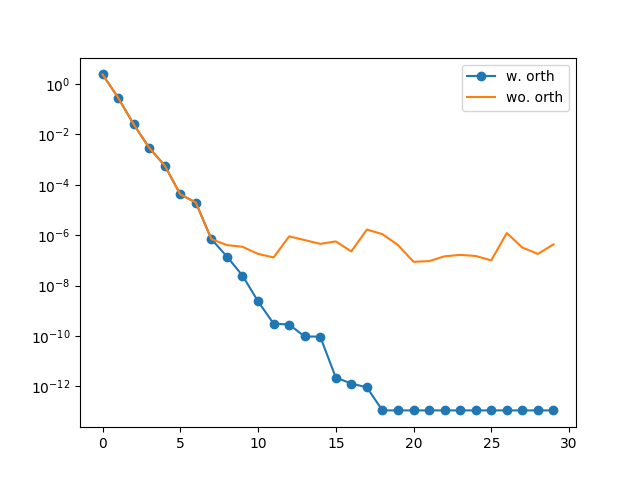

In [13]:
from matplotlib import pyplot as plt
plt.figure()
plt.semilogy(errors_orth, marker='o', label='w. orth')
plt.semilogy(errors, label='wo. orth')
plt.legend()
plt.show()

2. Erweitern Sie auch `greedy_approximation`, sodass in jeder Iteration der neu gewählte Basisvektor zur bestehenden Basis ortogonalisiert wird. Nutzen Sie hierzu den `offset`-Parameter der `gram_schmidt`-Methode. Wiederholen Sie die Experimente von Blatt 5 Aufgabe 2 und vergleichen Sie. 

Wir berechnen die Approximationsräume mit dem Greedy-Algorithmus (mit und ohne Orthonormalisierung), den wir in `greedy_approximation` implementiert haben. Wieder zeigt sich eine höhere numerische Stabilität, wenn die Basis im Greedy-Algorithmus zusätzlich orthonormalisiert wird:

<IPython.core.display.Javascript object>


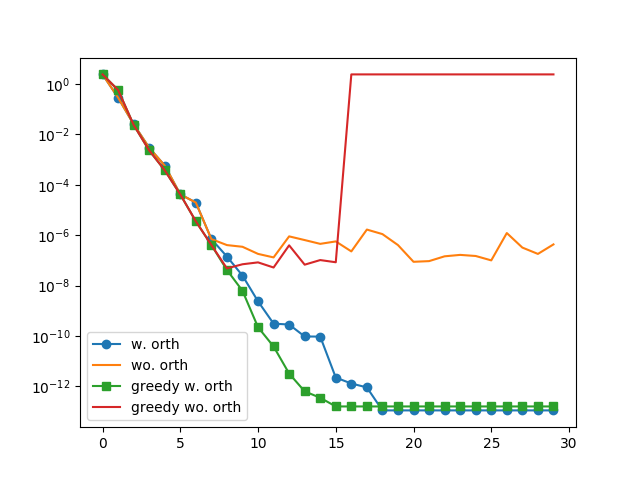

In [14]:
greedy_basis, _ = greedy_approximation(U, 30, product=d.h1_0_semi_product, orthogonalize=False)
greedy_orth_basis, _ = greedy_approximation(U, 30, product=d.h1_0_semi_product, orthogonalize=True)

errors_greedy = []
errors_greedy_orth = []
for N in range(len(U)):
    V_proj = orthogonal_projection(V, greedy_basis[:N], product=d.h1_0_semi_product)
    errors_greedy.append(np.max(d.h1_0_semi_norm(V - V_proj)))
    
    V_proj = orthogonal_projection(V, greedy_orth_basis[:N], product=d.h1_0_semi_product)
    errors_greedy_orth.append(np.max(d.h1_0_semi_norm(V - V_proj)))

plt.figure()
plt.semilogy(errors_orth, marker='o', label='w. orth')
plt.semilogy(errors, label='wo. orth')
plt.semilogy(errors_greedy_orth, marker='s', label='greedy w. orth')
plt.semilogy(errors_greedy, label='greedy wo. orth')
plt.legend()
plt.show()